In [21]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from sklearn import svm, metrics
from sklearn.utils import Bunch
from sklearn.model_selection import GridSearchCV, train_test_split
from skimage.io import imread
from skimage.transform import resize
import onnxruntime as rt

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Conv2D, Dropout, MaxPooling2D, BatchNormalization, Activation, Flatten, Dense, ZeroPadding2D, DepthwiseConv2D, ReLU, AvgPool2D, Input
from tensorflow.keras import Model
from keras.regularizers import l2
from keras.utils import to_categorical

import numpy as np
import os

np.random.seed(1000)


In [22]:
def load_image_files(images_dir_path, dimension=(224, 224)):
    images_dir = Path(images_dir_path)
    directories = [directory for directory in images_dir.iterdir()]
    classes = [class_directory.name.lower() for class_directory in directories]

    train_data = []

    for class_index, directory in enumerate(directories):
        for file in directory.iterdir():
            image = imread(file)
            image_resized = resize(image, dimension, anti_aliasing=True, mode='reflect')

            train_data.append(
                Bunch(
                    image=image,
                    image_resized=image_resized,
                    class_index=class_index,
                    class_name=classes[class_index],
                )
            )

    return train_data

In [23]:
image_dataset = load_image_files("groceries", dimension=(224, 224))
img_shape = (224, 224, 3)
num_classes = 25

# image_dataset = load_image_files("cifar-10", dimension=(64, 64))
# img_shape = (64, 64, 3)
# num_classes = 10

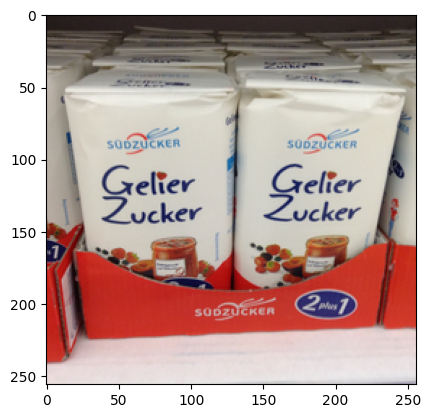

In [24]:
%matplotlib inline
plt.imshow(image_dataset[15].image)
plt.show()

In [25]:
x_train, x_test, y_train, y_test = train_test_split(
    list(map(lambda bunch: bunch.image_resized, image_dataset)), 
    list(map(lambda bunch: bunch.class_index, image_dataset)), 
    test_size=0.3,
    random_state=109
)

In [26]:
smallnet = Sequential()
smallnet.add(Conv2D(32, (3,3), padding='same', activation="relu",input_shape=img_shape))
smallnet.add(MaxPooling2D((2, 2), strides=2))
smallnet.add(Conv2D(64, (3,3), padding='same', activation="relu"))
smallnet.add(MaxPooling2D((2, 2), strides=2))
smallnet.add(Flatten())
smallnet.add(Dense(100, activation="relu"))
smallnet.add(BatchNormalization())
smallnet.add(Dense(num_classes, activation="softmax"))

smallnet.summary()

/Users/plenkinav/Projects/opencv-classifiers/.venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 200704)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │    20,070,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 25)             │         2,525 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,092,817 (76.65 MB)

 Trainable params: 20,092,617 (76.65 MB)

 Non-trainable params: 200 (800.00 B)

In [27]:
# def mobilnet_block (x, filters, strides):
#     x = DepthwiseConv2D(kernel_size = 3, strides = strides, padding = 'same')(x)
#     x = BatchNormalization()(x)
#     x = ReLU()(x)
    
#     x = Conv2D(filters = filters, kernel_size = 1, strides = 1)(x)
#     x = BatchNormalization()(x)
#     x = ReLU()(x)
    
#     return x

# input = Input(shape = (224,224,3))
# x = Conv2D(filters = 32, kernel_size = 3, strides = 2, padding = 'same')(input)
# x = BatchNormalization()(x)
# x = ReLU()(x)

# x = mobilnet_block(x, filters = 64, strides = 1)
# x = mobilnet_block(x, filters = 128, strides = 2)
# x = mobilnet_block(x, filters = 128, strides = 1)
# x = mobilnet_block(x, filters = 256, strides = 2)
# x = mobilnet_block(x, filters = 256, strides = 1)
# x = mobilnet_block(x, filters = 512, strides = 2)
# for _ in range (5):
#     x = mobilnet_block(x, filters = 512, strides = 1)
# x = mobilnet_block(x, filters = 1024, strides = 2)
# x = mobilnet_block(x, filters = 1024, strides = 1)
# x = AvgPool2D (pool_size = 7, strides = 1, data_format='channels_first')(x)
# x = Flatten()(x)
# output = Dense (units = 25, activation = 'softmax')(x)

# smallnet = Model(inputs=input, outputs=output)
# smallnet.summary()

In [28]:
opt = keras.optimizers.Adam(learning_rate=0.01)
smallnet.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [29]:
callback = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        mode="auto",
        restore_best_weights=True,
        patience=3
    ),
    tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.keras'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs')
]

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

hist = smallnet.fit(
    np.array(x_train), 
    to_categorical(y_train), 
    batch_size=15, 
    epochs=15, 
    verbose=1, 
    validation_split=0.2, 
    shuffle=True, 
    callbacks=[callback]
)

Epoch 1/15
185/185 ━━━━━━━━━━━━━━━━━━━━ 35s 178ms/step - accuracy: 0.0936 - loss: 3.1990 - val_accuracy: 0.0866 - val_loss: 5.1020
Epoch 2/15
185/185 ━━━━━━━━━━━━━━━━━━━━ 31s 168ms/step - accuracy: 0.2237 - loss: 2.6639 - val_accuracy: 0.1760 - val_loss: 3.1260
Epoch 3/15
185/185 ━━━━━━━━━━━━━━━━━━━━ 31s 166ms/step - accuracy: 0.2839 - loss: 2.4605 - val_accuracy: 0.0534 - val_loss: 5.9741
Epoch 4/15
185/185 ━━━━━━━━━━━━━━━━━━━━ 31s 165ms/step - accuracy: 0.3018 - loss: 2.4037 - val_accuracy: 0.1097 - val_loss: 8.9971
Epoch 5/15
185/185 ━━━━━━━━━━━━━━━━━━━━ 31s 165ms/step - accuracy: 0.4333 - loss: 1.9521 - val_accuracy: 0.0736 - val_loss: 7.9734


In [30]:
predict_x = smallnet.predict(np.array(x_test)) 
y_pred = np.argmax(predict_x, axis=1)
y_true = np.array(y_test)

47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step


In [31]:
from sklearn.metrics import accuracy_score

acc_score = (accuracy_score(y_true, y_pred))*100
print('Accuracy Score = ', acc_score)

Accuracy Score =  17.44107744107744


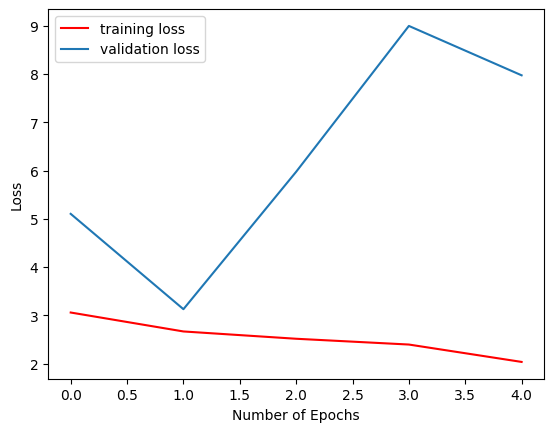

In [32]:
plt.plot(hist.history['loss'],'r',label='training loss')
plt.plot(hist.history['val_loss'],label='validation loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [33]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.04      0.08        25
           1       0.00      0.00      0.00        38
           2       0.23      0.13      0.16        54
           3       0.40      0.02      0.04        84
           4       0.67      0.04      0.08        47
           5       0.19      0.24      0.22        58
           6       0.00      0.00      0.00        59
           7       0.16      0.43      0.24        47
           8       0.20      0.28      0.24        43
           9       0.20      0.28      0.24        94
          10       0.23      0.06      0.10        50
          11       0.17      0.04      0.06        51
          12       0.09      0.60      0.16        68
          13       0.15      0.17      0.16        58
          14       0.16      0.46      0.24        94
          15       0.50      0.02      0.04        93
          16       0.25      0.02      0.04        49
          17       0.00    

/Users/plenkinav/Projects/opencv-classifiers/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/plenkinav/Projects/opencv-classifiers/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/plenkinav/Projects/opencv-classifiers/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

In [34]:
import tensorflow as tf
import tf2onnx
import onnx

input_signature = [tf.TensorSpec([1, 224, 224, 3], tf.double, name='x')]
# input_signature = [tf.TensorSpec([1, 64, 64, 3], tf.double, name='x')]
smallnet.output_names=['output']

onnx_model, _ = tf2onnx.convert.from_keras(smallnet, input_signature, opset=13)
onnx.save(onnx_model, "smallnet_groceries_224_224_3.onnx")
# onnx.save(onnx_model, "smallnet_cifar10_64_64_3.onnx")

In [35]:
session = rt.InferenceSession("smallnet_groceries_224_224_3.onnx", providers=["CPUExecutionProvider"])
# session = rt.InferenceSession("smallnet_cifar10_64_64_3.onnx", providers=["CPUExecutionProvider"])
input_name = session.get_inputs()[0].name
np.argmax(session.run(None, {input_name: np.array([np.array(x_test)[20]])})[0][0])

12

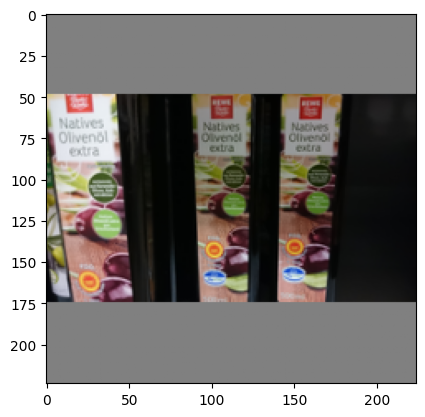

In [36]:
plt.imshow(x_test[20])
plt.show()